# Replay demonstration

In [1]:
%reset -f
%matplotlib inline
from replay import plot, smln

# SMLN result 390
p = {
    "A_P": 2, "B_C": 0.2, "B_S": 0.01, "C_S": 10, "E_E": 0, "E_I": -0.08, "T_C": 1.5, "T_E": 0.002, "T_I": 0.005,
    "T_W": 1, "A_TR": 0.008, "L_PL": 0.2, "N_PC": 1000, "R_TR": 0.4, "S_TH": 0.1, "N_INH": 100, "R_MAX": 600,
    "D_T_TR": 0.004934535755932959, "E_L_PC": -0.068, "T_M_PC": 0.05, "T_R_PC": 0.008, "V_R_PC": -0.068,
    #"E_L_INH": -0.058, "L_PC_PC": 0.07704824643153575, "T_M_INH": 0.009, "T_R_INH": 0.002, "V_R_INH": -0.058,
    "E_L_INH": -0.058, "L_PC_PC": 0.08004824643153575, "T_M_INH": 0.009, "T_R_INH": 0.002, "V_R_INH": -0.058,
    "V_TH_PC": -0.036, "Z_PC_PC": 1.1890493842838763, "E_AHP_PC": -0.07, "L_INH_PC": 0.04642888730043733,
    "T_AHP_PC": 0.05, "V_TH_INH": -0.036, "W_AHP_PC": 0.0, "Z_INH_PC": 0.9350952880151053, "S_E_PC_PC": 0,
    "S_E_PC_PL": 0, "W_E_PC_PC": 0.026413547327228105, "W_E_PC_PL": 0.02, "L_C_PC_INH": 0.05618141451584645,
    "L_S_PC_INH": 0.0823735501738046, "S_E_INH_PC": 0, "S_I_PC_INH": 0, "W_E_INH_PC": 0.01032327536045837,
    "W_I_PC_INH": 0, "Z_C_PC_INH": 2.9988788471151953, "Z_S_PC_INH": 3.068227337030645,
    "FR_RPL_PC_ST": 126.95015742215853, "FR_TRJ_PC_ST": 3, "S_E_INIT_PC_ST": 0, "W_E_INIT_PC_ST": 0.008215911661142529
}

s_params = {
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "END_X": 1, "SPEED": 0.2, "X_TRG": 1, "Y_TRG": -0.75,
    "TURN_X": 0, "TURN_Y": -0.75, "START_X": -1, "START_Y": 0.75,
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5
    },
    "RNG_SEED": 0,
    "schedule": {"SMLN_DUR": 22, "TRG_START_T": 21, "TRJ_START_T": 1, "REPLAY_EPOCH_START_T": 20}}

apxn = True

print('Running smln...')
rslt = smln.run(p, s_params, apxn)
print('Smln complete.')

Running smln...
Smln complete.


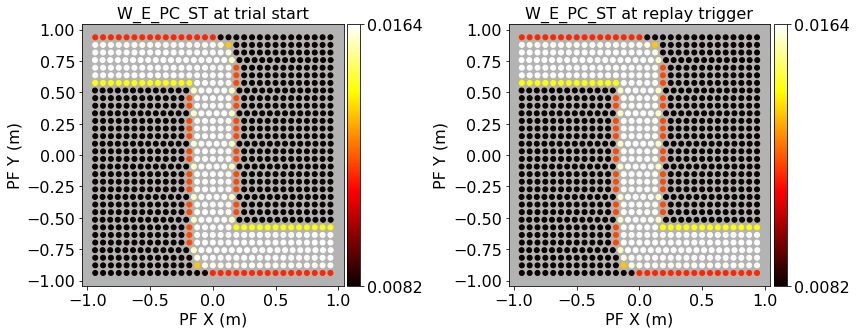

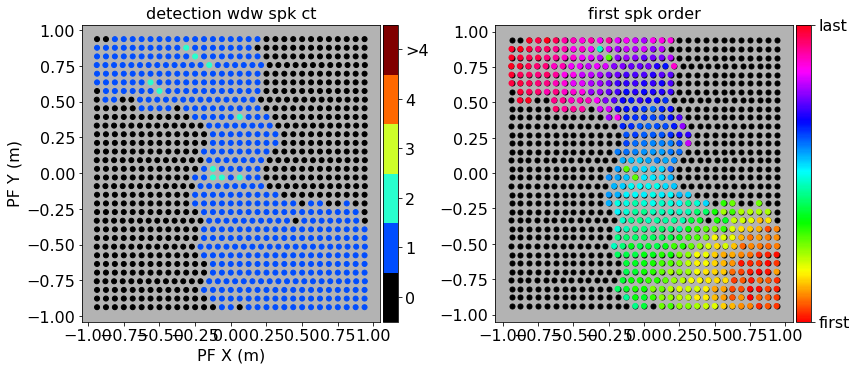

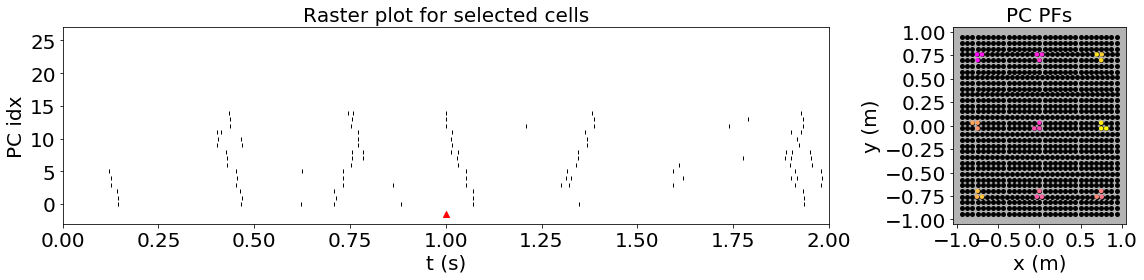

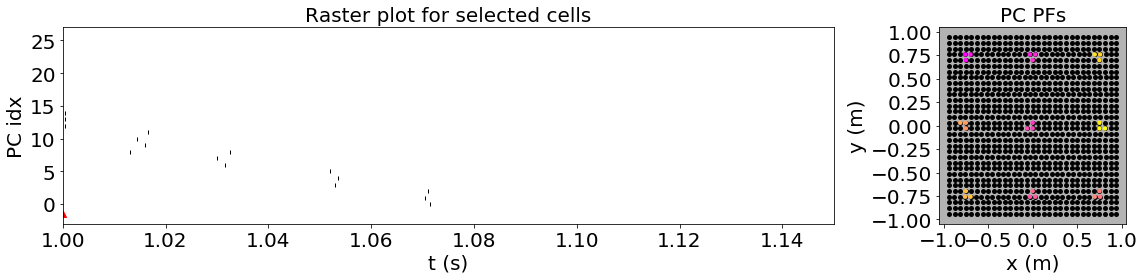

In [2]:
# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));

# Extended run

In [3]:
%reset -f
%matplotlib inline
from replay import plot, smln

# SMLN result 390
p = {
    "A_P": 2, "B_C": 0.2, "B_S": 0.01, "C_S": 10, "E_E": 0, "E_I": -0.08, "T_C": 1.5, "T_E": 0.002, "T_I": 0.005,
    "T_W": 1, "A_TR": 0.008, "L_PL": 0.2, "N_PC": 1000, "R_TR": 0.4, "S_TH": 0.1, "N_INH": 100, "R_MAX": 600,
    "D_T_TR": 0.004934535755932959, "E_L_PC": -0.068, "T_M_PC": 0.05, "T_R_PC": 0.008, "V_R_PC": -0.068,
    #"E_L_INH": -0.058, "L_PC_PC": 0.07704824643153575, "T_M_INH": 0.009, "T_R_INH": 0.002, "V_R_INH": -0.058,
    "E_L_INH": -0.058, "L_PC_PC": 0.08004824643153575, "T_M_INH": 0.009, "T_R_INH": 0.002, "V_R_INH": -0.058,
    "V_TH_PC": -0.036, "Z_PC_PC": 1.1890493842838763, "E_AHP_PC": -0.07, "L_INH_PC": 0.04642888730043733,
    "T_AHP_PC": 0.05, "V_TH_INH": -0.036, "W_AHP_PC": 0.0, "Z_INH_PC": 0.9350952880151053, "S_E_PC_PC": 0,
    "S_E_PC_PL": 0, "W_E_PC_PC": 0.026413547327228105, "W_E_PC_PL": 0.02, "L_C_PC_INH": 0.05618141451584645,
    "L_S_PC_INH": 0.0823735501738046, "S_E_INH_PC": 0, "S_I_PC_INH": 0, "W_E_INH_PC": 0.01032327536045837,
    "W_I_PC_INH": 0, "Z_C_PC_INH": 2.9988788471151953, "Z_S_PC_INH": 3.068227337030645,
    "FR_RPL_PC_ST": 126.95015742215853, "FR_TRJ_PC_ST": 3, "S_E_INIT_PC_ST": 0, "W_E_INIT_PC_ST": 0.008215911661142529
}

s_params = {
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "END_X": 1, "SPEED": 0.2, "X_TRG": 1, "Y_TRG": -0.75,
    "TURN_X": 0, "TURN_Y": -0.75, "START_X": -1, "START_Y": 0.75,
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5
    },
    "RNG_SEED": 0,
    "schedule": {"SMLN_DUR": 30, "TRG_START_T": 21, "TRJ_START_T": 1, "REPLAY_EPOCH_START_T": 20}}

apxn = True

print('Running smln...')
rslt = smln.run(p, s_params, apxn)
print('Smln complete.')

Running smln...
Smln complete.


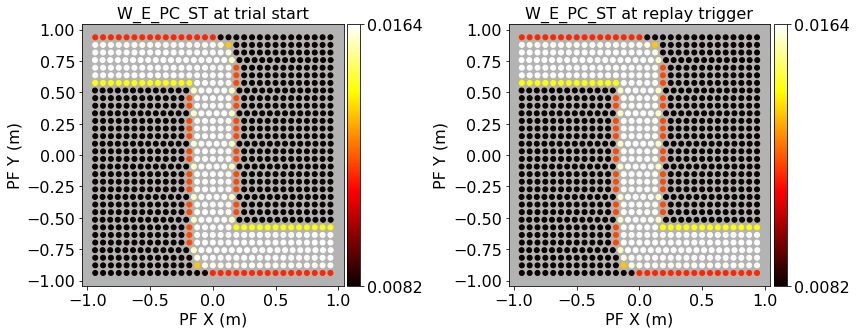

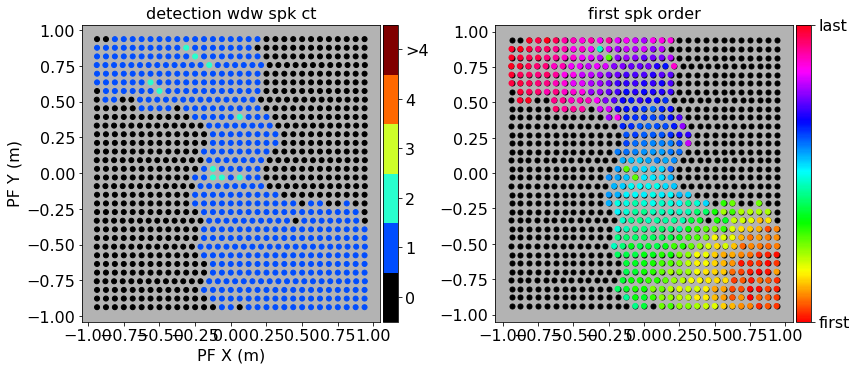

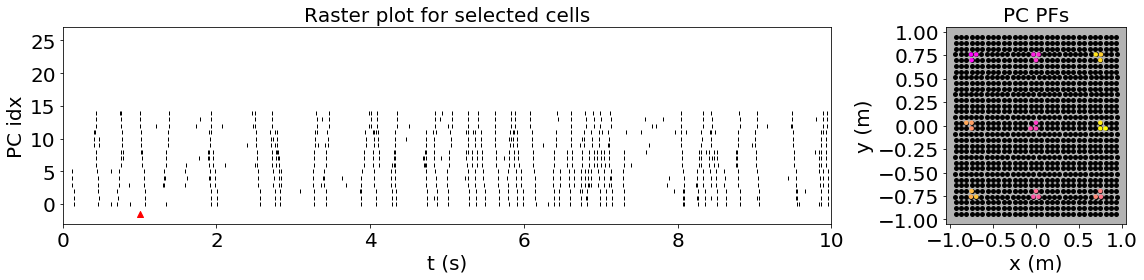

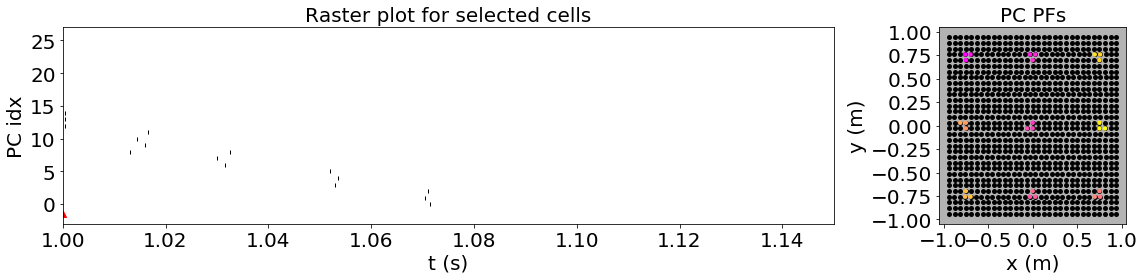

In [4]:
# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));

# New params

Running smln...
Smln complete.


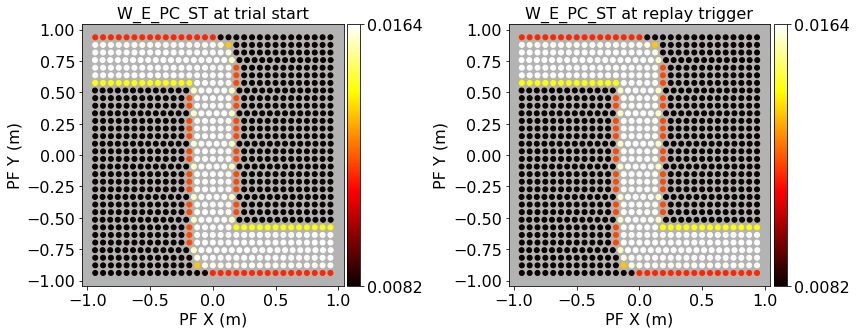

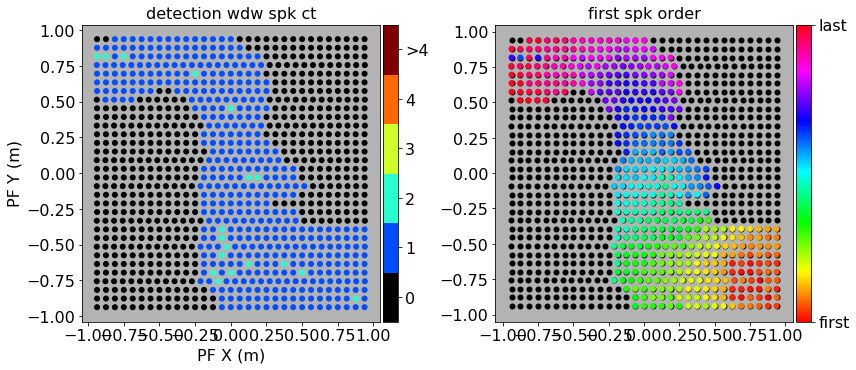

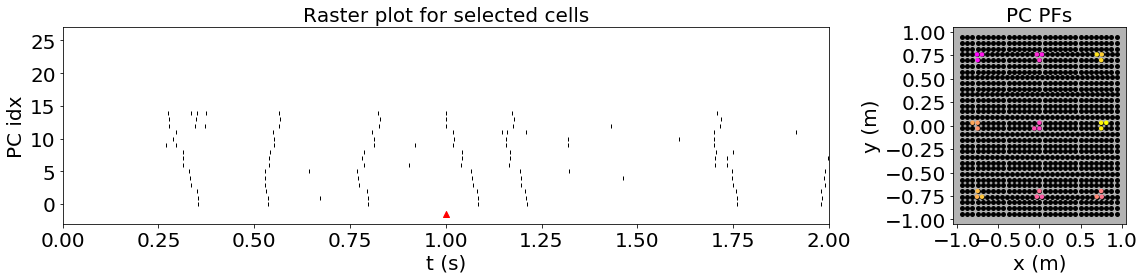

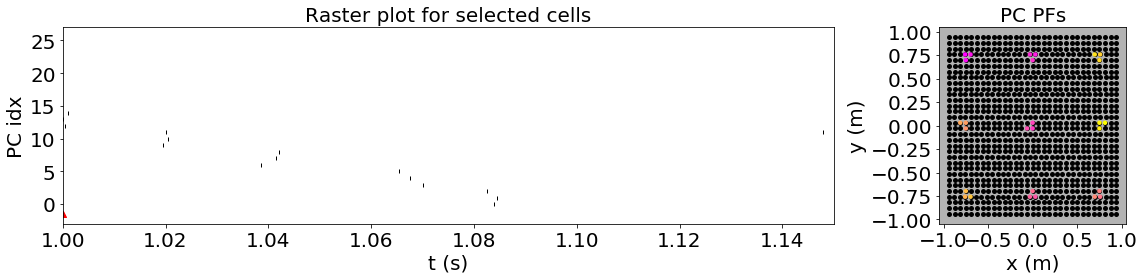

In [36]:
%reset -f
%matplotlib inline
from replay import plot, smln

# reslt 1025/2196
p = {
    'Z_INH_PC': 0., 'Z_S_PC_INH': 0.,
    'S_E_PC_PC': 0, 'T_E': 0.002, 'L_C_PC_INH': 0.1, 'S_E_INIT_PC_ST': 0,
    'E_L_PC': -0.068, 'FR_TRJ_PC_ST': 3, 'T_M_PC': 0.05, 'E_AHP_PC': -0.07,
    'Z_PC_PC': 1.1890493842838763, 'S_E_INH_PC': 0, 'V_R_PC': -0.068, 'W_E_PC_PL': 0.02,
    'C_S': 10, 'R_TR': 0.4, 'T_R_PC': 0.008, 'E_I': -0.08, 'S_TH': 0.1, 'V_TH_INH': -0.036,
    'S_E_PC_PL': 0, 'W_E_PC_PC': 0.022, 'L_PC_PC': 0.088, 'D_T_TR': 0.004934535755932959,
    'L_INH_PC': 0.1, 'T_AHP_PC': 0, 'W_E_INIT_PC_ST': 0.008215911661142529,
    'W_E_INH_PC': 0.01032327536045837, 'L_PL': 0.2, 'L_S_PC_INH': 0.0823735501738046, 'E_E': 0,
    'FR_RPL_PC_ST': 126.95015742215853, 'S_I_PC_INH': 0, 'B_S': 0.01, 'V_TH_PC': -0.036,
    'T_R_INH': 0.002, 'Z_C_PC_INH': 2.9988788471151953, 'N_INH': 100, 'T_W': 1, 'V_R_INH': -0.058,
    'T_M_INH': 0.009, 'W_I_PC_INH': 0, 'R_MAX': 600, 'W_AHP_PC': 0.0, 'T_C': 1.5, 'A_P': 2,
    'T_I': 0.005, 'E_L_INH': -0.058, 'N_PC': 1000, 'A_TR': 0.008, 'B_C': 0.2
}

s_params = {
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "END_X": 1, "SPEED": 0.2, "X_TRG": 1, "Y_TRG": -0.75,
    "TURN_X": 0, "TURN_Y": -0.75, "START_X": -1, "START_Y": 0.75,
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5
    },
    "RNG_SEED": 8,
    "schedule": {"SMLN_DUR": 22, "TRG_START_T": 21, "TRJ_START_T": 1, "REPLAY_EPOCH_START_T": 20}}

apxn = True

print('Running smln...')
rslt = smln.run(p, s_params, apxn)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));

Running smln...
Smln complete.


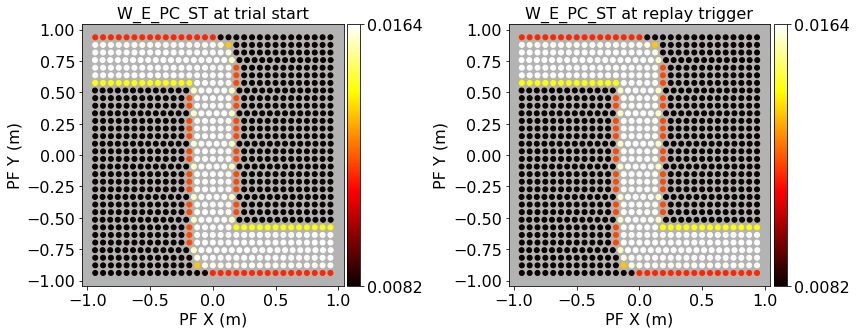

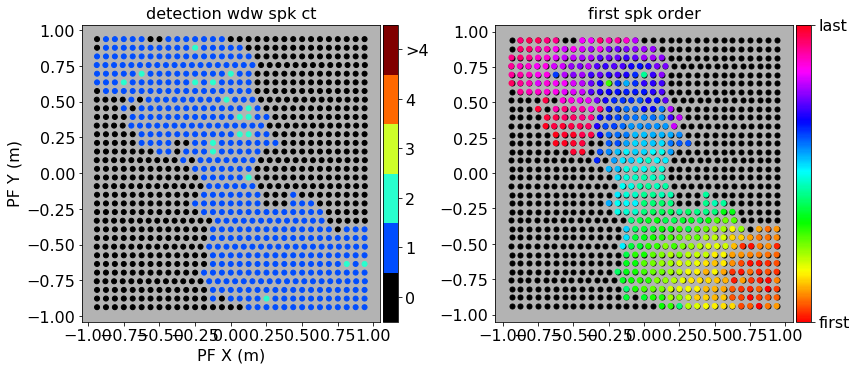

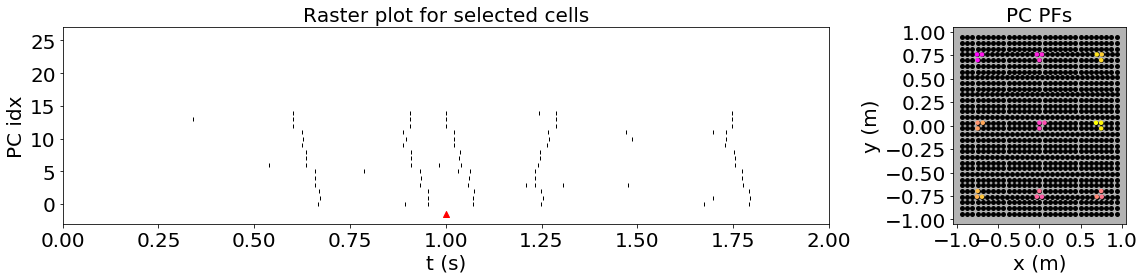

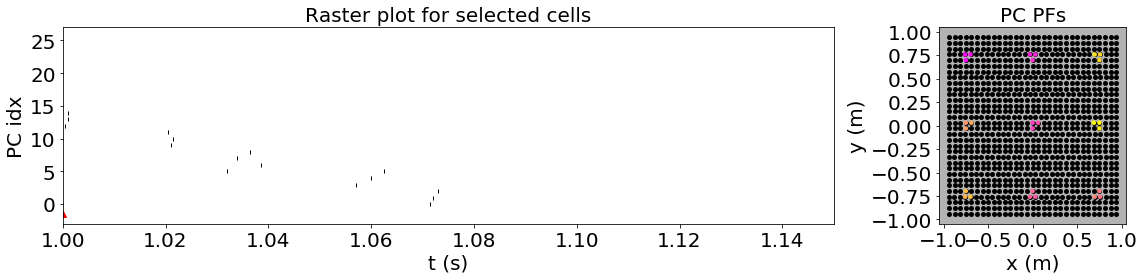

In [69]:
%reset -f
%matplotlib inline
from replay import plot, smln

p = {
    'N_PC': 1000, 'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    'T_AHP_PC': 0.05, 'W_AHP_PC': 0.0,
    
    'Z_PC_PC': 1.1890493842838763, 'L_PC_PC': 0.084,
    'W_E_PC_PC': 0.024, 'S_E_PC_PC': 0,
    
    'W_E_PC_PL': 0.02, 'L_PL': 0.2,
    
    'N_INH': 100, 'T_M_INH': 0.009, 'E_L_INH': -0.058,  'V_R_INH': -0.058, 'T_R_INH': 0.002,
     'V_TH_INH': -0.036, 
    
    'Z_S_PC_INH': 0.,  'L_S_PC_INH': 0.0823735501738046, 
    'Z_C_PC_INH': 2.9988788471151953, 'L_C_PC_INH': 0.05618141451584645,
    
    'W_E_INH_PC': 0.01032327536045837, 'S_E_INH_PC': 0, 
    
    'Z_INH_PC': 0., 'L_INH_PC': 0.04642888730043733, 
    
    'S_I_PC_INH': 0,
    'W_I_PC_INH': 0, 
    
    'W_E_INIT_PC_ST': 0.008215911661142529, 'S_E_INIT_PC_ST': 0,
    
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
     'E_AHP_PC': -0.07,
    
    'FR_TRJ_PC_ST': 3, 'FR_RPL_PC_ST': 126.95015742215853, 
    
    
    'C_S': 10, 'R_TR': 0.4, 
    'S_TH': 0.1, 'S_E_PC_PL': 0, 
    
    'D_T_TR': 0.004934535755932959, 
    
    
    'B_S': 0.01,
    'T_W': 1,
    'R_MAX': 600, 'T_C': 1.5, 'A_P': 2,
    'A_TR': 0.008, 'B_C': 0.2
}

s_params = {
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "END_X": 1, "SPEED": 0.2, "X_TRG": 1, "Y_TRG": -0.75,
    "TURN_X": 0, "TURN_Y": -0.75, "START_X": -1, "START_Y": 0.75,
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5
    },
    "RNG_SEED": 5,
    "schedule": {"SMLN_DUR": 22, "TRG_START_T": 21, "TRJ_START_T": 1, "REPLAY_EPOCH_START_T": 20}}

apxn = True

print('Running smln...')
rslt = smln.run(p, s_params, apxn)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));

Running smln...
Smln complete.


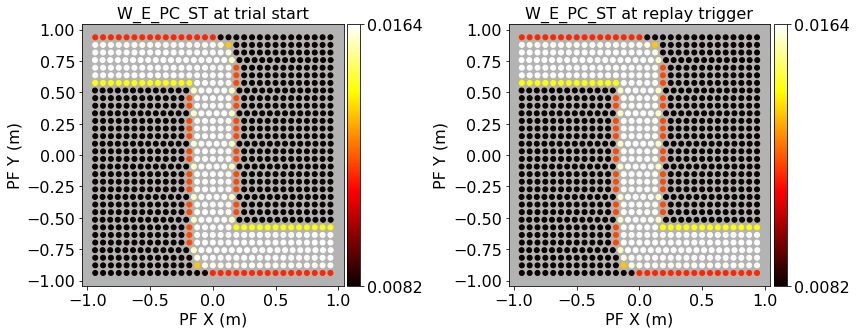

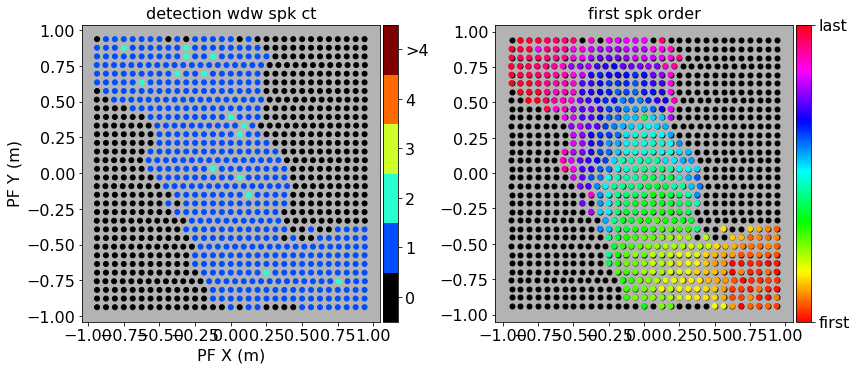

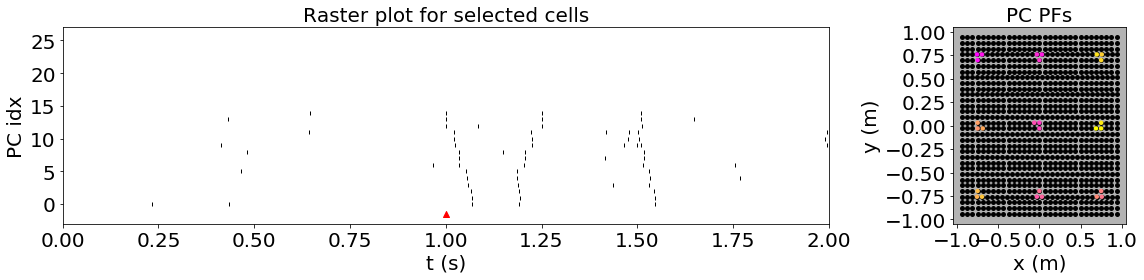

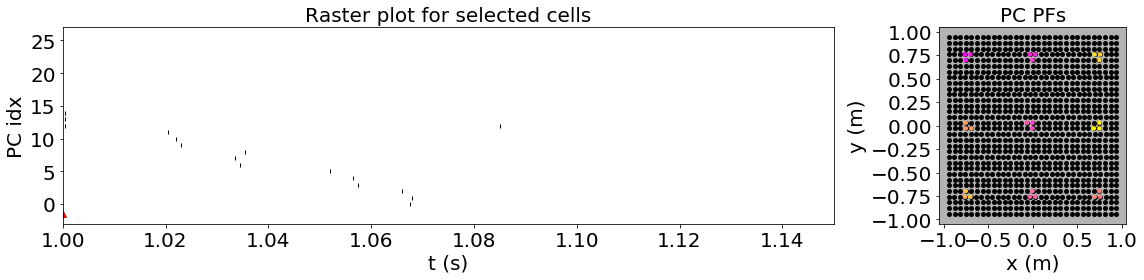

In [61]:
%reset -f
%matplotlib inline
from replay import plot, smln

# reslt 1345/2196
p = {
    'Z_INH_PC': 0.9350952880151053, 'Z_S_PC_INH': 3.068227337030645, 'S_E_PC_PC': 0, 'T_E': 0.002,
    'L_C_PC_INH': 0.05618141451584645, 'S_E_INIT_PC_ST': 0, 'E_L_PC': -0.068, 'FR_TRJ_PC_ST': 3,
    'T_M_PC': 0.05, 'E_AHP_PC': -0.07, 'Z_PC_PC': 1.1890493842838763, 'S_E_INH_PC': 0, 'V_R_PC': -0.068,
    'W_E_PC_PL': 0.02, 'C_S': 10, 'R_TR': 0.4, 'T_R_PC': 0.008, 'E_I': -0.08, 'S_TH': 0.1, 'V_TH_INH': -0.036,
    'S_E_PC_PL': 0, 'W_E_PC_PC': 0.018000000000000002, 'L_PC_PC': 0.097, 'D_T_TR': 0.004934535755932959,
    'L_INH_PC': 0.04642888730043733, 'T_AHP_PC': 0.05, 'W_E_INIT_PC_ST': 0.008215911661142529,
    'W_E_INH_PC': 0.01032327536045837, 'L_PL': 0.2, 'L_S_PC_INH': 0.0823735501738046, 'E_E': 0,
    'FR_RPL_PC_ST': 126.95015742215853, 'S_I_PC_INH': 0, 'B_S': 0.01, 'V_TH_PC': -0.036,
    'T_R_INH': 0.002, 'Z_C_PC_INH': 2.9988788471151953, 'N_INH': 100, 'T_W': 1, 'V_R_INH': -0.058,
    'T_M_INH': 0.009, 'W_I_PC_INH': 0, 'R_MAX': 600, 'W_AHP_PC': 0.0, 'T_C': 1.5, 'A_P': 2, 'T_I': 0.005,
    'E_L_INH': -0.058, 'N_PC': 1000, 'A_TR': 0.008, 'B_C': 0.2}

s_params = {
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "END_X": 1, "SPEED": 0.2, "X_TRG": 1, "Y_TRG": -0.75,
    "TURN_X": 0, "TURN_Y": -0.75, "START_X": -1, "START_Y": 0.75,
    "metrics": {
        "WDW": 0.1, "PITCH": 10, "RADIUS": 0.2, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5
    },
    "RNG_SEED": 9,
    "schedule": {"SMLN_DUR": 22, "TRG_START_T": 21, "TRJ_START_T": 1, "REPLAY_EPOCH_START_T": 20}}

apxn = True

print('Running smln...')
rslt = smln.run(p, s_params, apxn)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, (1, 1.15));

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch='replay');

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
    ],
    nearest=3,
    epoch=(1, 1.15));